# 🌏 Sentinel QuickView 🌏
A Jupyter notebook for the quick viewing of Sentinel2 images for a geometry subset and time range 


## Features  📄 
* Select a Geometry from a map view to fetch Sentinel2 images for 
* Plot RGB and NDVI images for a user defined geometry and time range 
* Diff' NDVI for selected times 
* Write out RGB and NDVI rasters ready to add to a GIS 

## Usage 🔨 
Instructions are embedded in the notebook. Where green text is encountered, the users must edit variables.  
 

## Install Dependencies ↔️
1.  Create a Conda Environment 

    `conda create --name quickview python=3.11` 

2. Activate the newly created environment 

   `conda activate quickview` 

3. Install requirements via pip 

   `pip install -r requirements.txt` 

4. You are now ready to start the notebook (Jupyter)

## Limitations 🐍
This is for fetching small image extents and date ranges. Large extents and date ranges will be slow


In [1]:
import os
#from copy import deepcopy
import planetary_computer
from ipyleaflet import Map, basemaps, DrawControl
import geojson
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
import rioxarray
import stackstac
import xarray as xr
import xrspatial.multispectral as ms
from dask.distributed import Client, progress
#from shapely.geometry import shape
#from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean #focal_stats, hotspots, mean

<div style="background-color: #03fc62; padding: 10px;">
    
###  User Input Required
* **date_range**: The date range of imagery to fetch (in format of yyyy-mm-dd/yyyy-mm-dd)

</div>


In [2]:
# EDIT THE BELOW
date_range = "2023-01-01/2023-04-01"

In [3]:
# The Dask Client - Local in the case
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


In [4]:
# Open the Stac Client
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

<div style="background-color: #03fc62; padding: 10px;">
    
###  User Input Required
Draw a rectangle polygon on the below map to define the Area of Interest 

</div>

In [6]:
m = Map(basemap=basemaps.Esri.WorldImagery)
lat = -41.672912
long = 173.913574
m.center = lat, long
m.zoom = 5
m.layout.height = "700px"
m.scroll_wheel_zoom = True

draw_control = DrawControl()

draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 0.5
    }
}

m.add_control(draw_control)

def handle_draw(self, action, geo_json):
    global drawn_polygon_geojson
    drawn_polygon_geojson = geo_json
    html_widget.value = geo_json

draw_control.on_draw(handle_draw)

m

Map(center=[-41.672912, 173.913574], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [7]:
geom = drawn_polygon_geojson['geometry']

In [10]:
### Alternatively, provide you own coordinates 
### These can be fetch from QGIS as below. ensure you are projectng to WGS84
### QgsGeometry.fromRect(iface.mapCanvas().extent()).asJson()

# EDIT THE BELOW TO PROVIDE A AOI WITHOUT USING THE ABOVE MAP VIEW#
#geo`m ={"coordinates":[[[172.62821680828986,-34.492267518416206],[172.7073912999182,-34.492267518416206],[172.7073912999182,-34.43969001952619],[172.62821680828986,-34.43969001952619],[172.62821680828986,-34.492267518416206]]],"type":"Polygon"}

In [8]:
geom

{'type': 'Polygon',
 'coordinates': [[[172.632809, -34.483392],
   [172.632809, -34.461881],
   [172.671089, -34.461881],
   [172.671089, -34.483392],
   [172.632809, -34.483392]]]}

In [9]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geom,
    datetime=date_range,
    query={"eo:cloud_cover": {"lt": 50}},
)

matched = search.matched()
if matched is not None:
    print(f"{search.matched()} scenes found")

/home/planzers/.local/lib/python3.8/site-packages/pystac_client/item_search.py:679: UserWarning: numberMatched or context.matched not in response
  warnings.warn("numberMatched or context.matched not in response")


In [10]:
# Get all items and report on how many are to be fetched

items_dict = [i.to_dict() for i in search.items()]
print(f"{len(items_dict)} scenes fetched")

8 scenes fetched


In [11]:
#stack = stackstac.stack(items_dict, ['B04', 'B03', 'B02'])
stack = (
    stackstac.stack(
        items_dict,
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        epsg=2193,
        
        chunksize=256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round("D"),  # round time to daily for nicer plot labels
    )
)

stack

if stack.get_index("time").duplicated().any():
    stack = stack.groupby('time').apply(lambda x: x.isel(time=0))
    

In [12]:
# Clip the Xarray to our geom
subset = stack.rio.clip([geom], crs='EPSG:4326')
subset

<xarray.DataArray 'stackstac-541e17f07f14ef050ec1abfe7730dec5' (time: 8,
                                                                band: 4,
                                                                y: 235, x: 345)>
dask.array<getitem, shape=(8, 4, 235, 345), dtype=float64, chunksize=(1, 1, 235, 190), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 2023-01-12...
    id                                       (time) <U54 'S2B_MSIL2A_20230111...
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 1.566e+06 ... 1.57e+06
  * y                                        (y) float64 6.187e+06 ... 6.184e+06
    s2:product_uri                           (time) <U65 'S2B_MSIL2A_20230111...
    ...                                       ...
    proj:transform                           object {0.0, 600000.0, 10.0, 620...
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 2193
    spatial_ref                              int64 0
Attributes:
    spec:           RasterSpec(epsg=2193, bounds=(1516026.1673002888, 6090396...
    resolution_xy:  (10.194582488620654, 10.194582488387823)

<div style="background-color: #03fc62; padding: 10px;">
    
###  Wait for the below to complete
Wait for the below loading to memory of the subset to complete so we can then access it for calculations 
</div>

In [13]:
subset = subset.persist()
progress(subset)

VBox()

In [14]:
# Set the paramters of the plot axis
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.labelleft": False,
    "ytick.left": False,
}

plt.rcParams.update(rc)

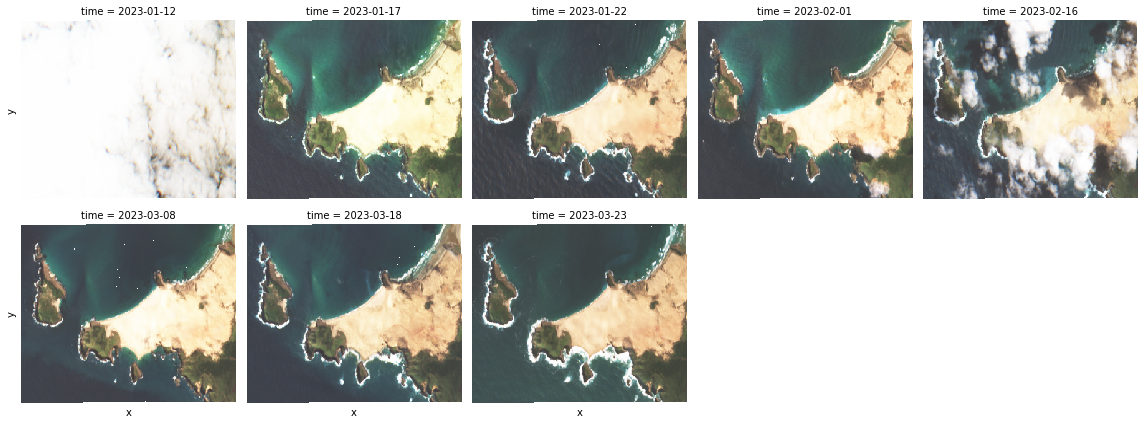

In [15]:
# Plot thge True Colour Images
true_color_aggs = [
    ms.true_color(x.sel(band="red"), x.sel(band="green"), x.sel(band="blue"))
    for x in subset
]

true_color = xr.concat(true_color_aggs, dim=subset.coords["time"])

# visualize
t = true_color.plot.imshow(x="x", y="y", col="time", col_wrap=5)

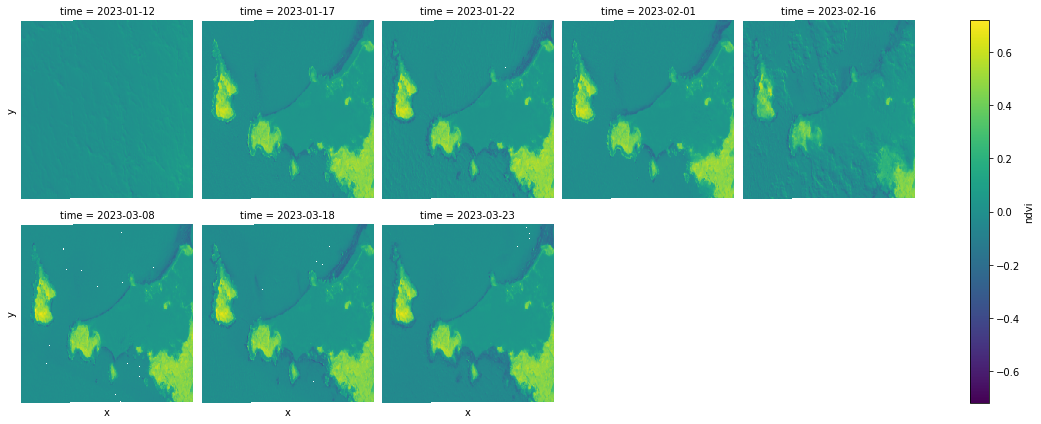

In [16]:
# Plot the NDVI Images
ndvi_aggs = [ms.ndvi(x.sel(band="nir"), x.sel(band="red")) for x in subset]
ndvi = xr.concat(ndvi_aggs, dim="time")
ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");

In [17]:
# NDVI Smoothed - The below procussed smoothed NDVI outputs
# mean_aggs = [mean(ndvi_agg) for ndvi_agg in ndvi_aggs]
# smooth = xr.concat(mean_aggs, dim="time")
# s = smooth.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis")

## Select NDVI dates for diff'ing

<div style="background-color: #03fc62; padding: 10px;">
    
###  User Input Required
Populate the below variables
* **pre_event_date / post_event_date**: The date for creating and NDVI diff. These dates also inform which rasters are written out.  
* **out_directory**: where to write out NDVIs, NDVI diff' and RGB images
</div>

In [20]:
pre_event_date='2023-01-17'
post_event_date='2023-03-08'
out_directory = 'output/vanDiemen'

pre_event_ndvi = ndvi.sel(time=pre_event_date)
post_event_ndvi = ndvi.sel(time=post_event_date)
#pre_event_smoothed_ndvi = smooth.sel(time=pre_event_date)
#post_event_smoothed_ndvi = smooth.sel(time=post_event_date)
pre_event_true_color = true_color.sel(time=pre_event_date).isel(band=slice(0, 3)).transpose('band', 'y', 'x')
post_event_true_color = true_color.sel(time=post_event_date).isel(band=slice(0, 3)).transpose('band', 'y', 'x')

## Change NDVI

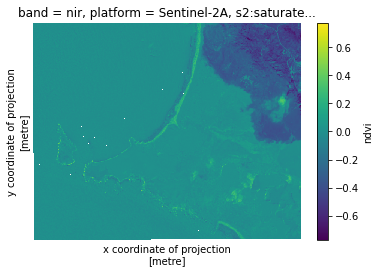

In [21]:
ndvi_diff = pre_event_ndvi-post_event_ndvi
ndvi_diff.plot.imshow(x="x", y="y", col_wrap=5, cmap="viridis")

## Export Images

In [22]:
# Check if the directory exists
if not os.path.exists(out_directory):
    # Create the directory if it doesn't exist
    os.makedirs(out_directory)

In [23]:
# The epsg values is not set for true colour so take it form the ndvi
espg = pre_event_ndvi.rio.crs
pre_event_true_color_crs= pre_event_true_color.rio.write_crs(espg)
post_event_true_color_crs= post_event_true_color.rio.write_crs(espg)

ndvi_diff.rio.to_raster(raster_path=f"{out_directory}/ndvi_diff_{pre_event_date}_{post_event_date}.tif", driver="COG")
# NDVI
pre_event_ndvi.rio.to_raster(raster_path=f"{out_directory}/{pre_event_date}_ndvi.tif", driver="COG")
post_event_ndvi.rio.to_raster(raster_path=f"{out_directory}/{post_event_date}_ndvi.tif", driver="COG")
# NDVI Smoothed
#pre_event_smoothed_ndvi.rio.to_raster(raster_path=f"{out_directory}/{pre_event_date}_ndvi_smoothed.tif", driver="COG")
#post_event_smoothed_ndvi.rio.to_raster(raster_path=f"{out_directory}/{post_event_date}_ndvi_smoothed.tif", driver="COG")
# RGB
pre_event_true_color_crs.rio.to_raster(raster_path=f"{out_directory}/{pre_event_date}_true_colour.tif", driver="COG")
post_event_true_color_crs.rio.to_raster(raster_path=f"{out_directory}/{post_event_date}_true_colour.tif", driver="COG")

## Or export all RGB

In [26]:

for time in true_color.time:
    time = time.dt.round("D")
    formatted_date = np.datetime_as_string(time, unit='D')
    rgb = true_color.sel(time=time).isel(band=slice(0, 3)).transpose('band', 'y', 'x')
    rgb = rgb.rio.write_crs("EPSG:2193")
    rgb.rio.to_raster(raster_path=f"{out_directory}/{formatted_date}_true_colour.tif", driver="COG")
